In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from crepes import (ConformalClassifier,
                    ConformalRegressor,
                    ConformalPredictiveSystem,
                    __version__)

from crepes.extras import hinge, margin, binning, DifficultyEstimator

print(f"crepes v. {__version__}")

np.random.seed(602211023)

crepes v. 0.7.1


# Conformal regressors (CR)

In [3]:
dataset = fetch_openml(name="house_sales", version=3, parser="auto")

X = dataset.data.values.astype(float)
y = dataset.target.values.astype(float)

y = np.array([(y[i]-y.min())/(y.max()-y.min()) for i in range(len(y))])

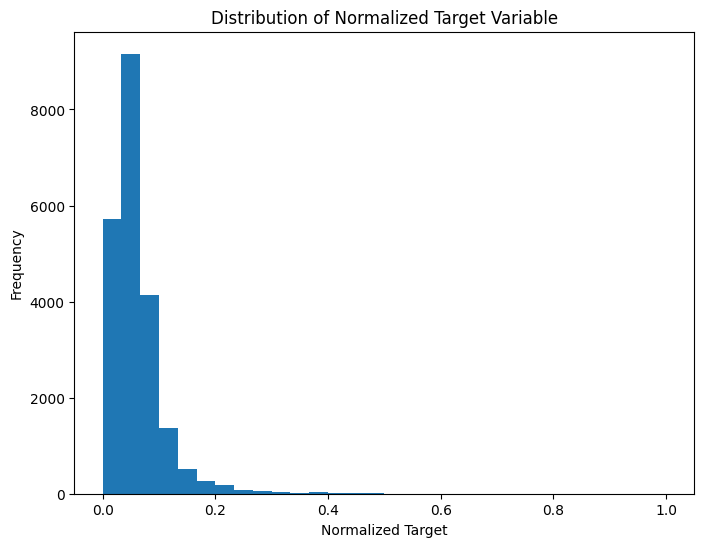

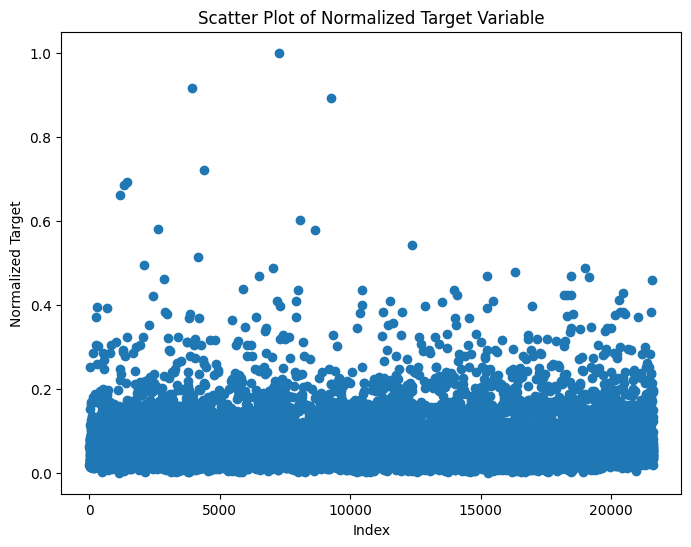

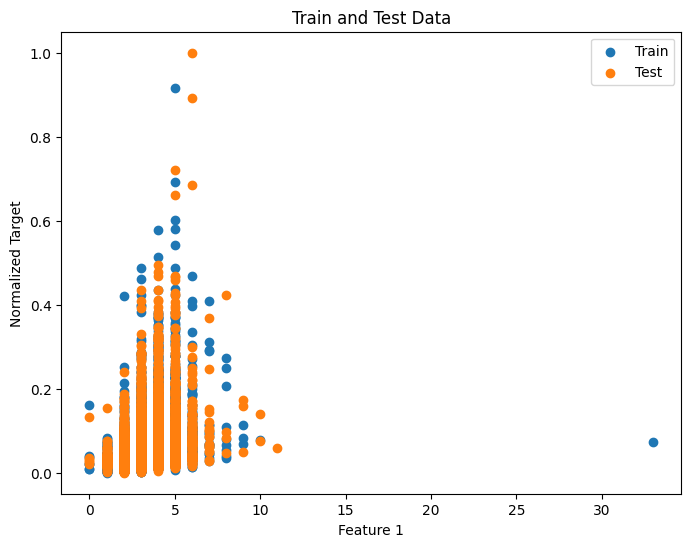

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Data Preprocessing
plt.figure(figsize=(8, 6))
plt.hist(y, bins=30)
plt.xlabel('Normalized Target')
plt.ylabel('Frequency')
plt.title('Distribution of Normalized Target Variable')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(range(len(y)), y)
plt.xlabel('Index')
plt.ylabel('Normalized Target')
plt.title('Scatter Plot of Normalized Target Variable')
plt.show()

# Train/Test Split
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], y_train, label='Train')
plt.scatter(X_test[:, 0], y_test, label='Test')
plt.xlabel('Feature 1')
plt.ylabel('Normalized Target')
plt.title('Train and Test Data')
plt.legend()
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

learner_prop = RandomForestRegressor(n_jobs=-1, n_estimators=500, oob_score=True)

learner_prop.fit(X_prop_train, y_prop_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True)

## Standard conformal regressors

In [ ]:
cr_std = ConformalRegressor()
display(cr_std)
y_hat_cal = learner_prop.predict(X_cal)

residuals_cal = y_cal - y_hat_cal

cr_std.fit(residuals_cal)

ConformalRegressor(fitted=False)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

In [9]:
y_hat_test = learner_prop.predict(X_test)

intervals = cr_std.predict(y_hat_test, confidence=0.99)

display(intervals)

array([[-0.03201615,  0.11384434],
       [-0.04521853,  0.10064197],
       [-0.00424899,  0.14161151],
       ...,
       [ 0.02452438,  0.17038488],
       [-0.04886076,  0.09699974],
       [-0.03928885,  0.10657165]])

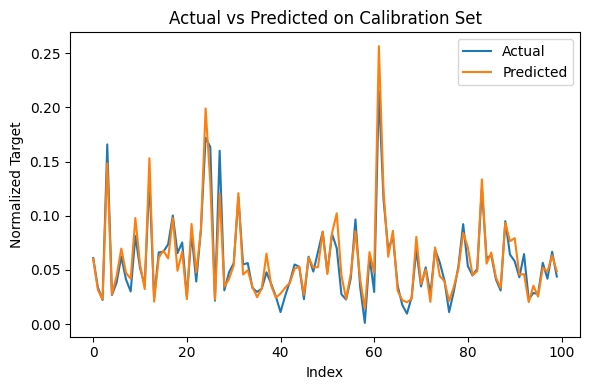

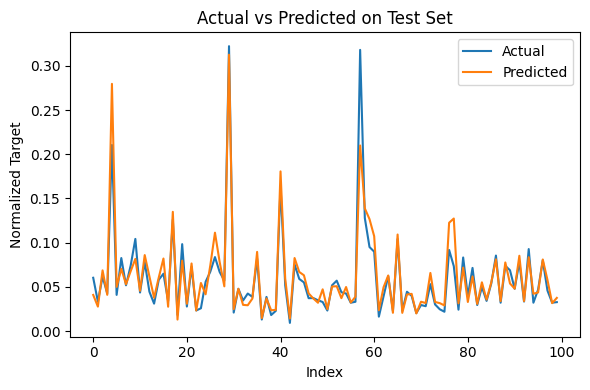

In [22]:
# Model Training
plt.figure(figsize=(6, 4))
plt.plot(range(100), y_cal[:100], label='Actual')
plt.plot(range(100), y_hat_cal[:100], label='Predicted')
plt.xlabel('Index')
plt.ylabel('Normalized Target')
plt.title('Actual vs Predicted on Calibration Set')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(100), y_test[:100], label='Actual')
plt.plot(range(100), y_hat_test[:100], label='Predicted')
plt.xlabel('Index')
plt.ylabel('Normalized Target')
plt.title('Actual vs Predicted on Test Set')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
intervals_std = cr_std.predict(y_hat_test, y_min=0, y_max=1)

display(intervals_std)

array([[0.01106069, 0.0707675 ],
       [0.        , 0.05756512],
       [0.03882786, 0.09853466],
       ...,
       [0.06760123, 0.12730803],
       [0.        , 0.05392289],
       [0.003788  , 0.0634948 ]])

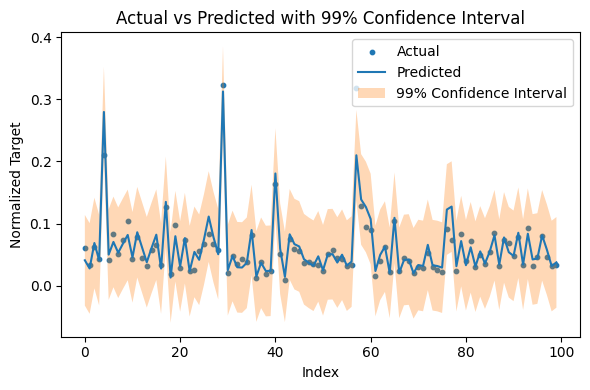

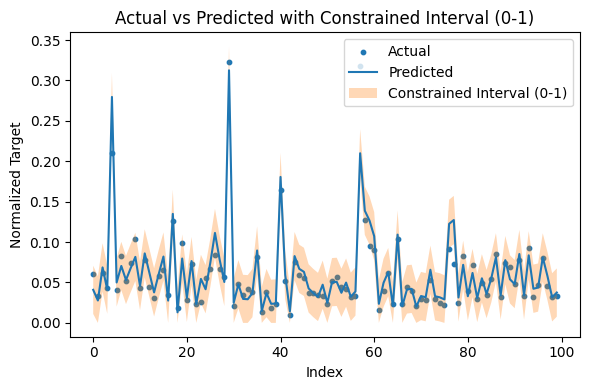

In [20]:
# Prediction Intervals
plt.figure(figsize=(6, 4))
plt.scatter(range(100), y_test[:100], label='Actual', s=10)
plt.plot(range(100), y_hat_test[:100], label='Predicted')
plt.fill_between(range(100), intervals[:100, 0], intervals[:100, 1], alpha=0.3, label='99% Confidence Interval')
plt.xlabel('Index')
plt.ylabel('Normalized Target')
plt.title('Actual vs Predicted with 99% Confidence Interval')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(range(100), y_test[:100], label='Actual', s=10)
plt.plot(range(100), y_hat_test[:100], label='Predicted')
plt.fill_between(range(100), intervals_std[:100, 0], intervals_std[:100, 1], alpha=0.3, label='Constrained Interval (0-1)')
plt.xlabel('Index')
plt.ylabel('Normalized Target')
plt.title('Actual vs Predicted with Constrained Interval (0-1)')
plt.legend()
plt.tight_layout()
plt.show()

## Normalized conformal regressors

In [25]:
de_knn = DifficultyEstimator()

de_knn.fit(X=X_prop_train, scaler=True)

display(de_knn)

sigmas_cal_knn_dist = de_knn.apply(X_cal)

cr_norm_knn_dist = ConformalRegressor()

cr_norm_knn_dist.fit(residuals_cal, sigmas=sigmas_cal_knn_dist)

display(cr_norm_knn_dist)

DifficultyEstimator(fitted=True, type=knn, k=25, target=none, scaler=True, beta=0.01, oob=False)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [26]:
sigmas_test_knn_dist = de_knn.apply(X_test)

intervals_norm_knn_dist = cr_norm_knn_dist.predict(y_hat_test,
                                                   sigmas=sigmas_test_knn_dist,
                                                   y_min=0, y_max=1)

display(intervals_norm_knn_dist)

array([[0.01656683, 0.06526136],
       [0.01237727, 0.04304617],
       [0.01389818, 0.12346434],
       ...,
       [0.07349902, 0.12141025],
       [0.00785926, 0.04027972],
       [0.02230872, 0.04497408]])

In [27]:
de_knn_std = DifficultyEstimator()

de_knn_std.fit(X=X_prop_train, y=y_prop_train, scaler=True)

display(de_knn_std)

sigmas_cal_knn_std = de_knn_std.apply(X_cal)

cr_norm_knn_std = ConformalRegressor()

cr_norm_knn_std.fit(residuals_cal, sigmas=sigmas_cal_knn_std)

display(cr_norm_knn_std)

DifficultyEstimator(fitted=True, type=knn, k=25, target=labels, scaler=True, beta=0.01, oob=False)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [28]:
sigmas_test_knn_std = de_knn_std.apply(X_test)

intervals_norm_knn_std = cr_norm_knn_std.predict(y_hat_test,
                                                 sigmas=sigmas_test_knn_std,
                                                 y_min=0, y_max=1)

display(intervals_norm_knn_std)

array([[0.0189916 , 0.06283659],
       [0.01355869, 0.04186474],
       [0.00241129, 0.13495123],
       ...,
       [0.07050463, 0.12440463],
       [0.01682092, 0.03131806],
       [0.00779812, 0.05948468]])

In [31]:
oob_predictions = learner_prop.oob_prediction_

residuals_oob = y_prop_train - oob_predictions

de_knn_res = DifficultyEstimator()

de_knn_res.fit(X=X_prop_train, residuals=residuals_oob, scaler=True)

display(de_knn_res)

sigmas_cal_knn_res = de_knn_res.apply(X_cal)

cr_norm_knn_res = ConformalRegressor()

cr_norm_knn_res.fit(residuals_cal, sigmas=sigmas_cal_knn_res)

display(cr_norm_knn_res)

DifficultyEstimator(fitted=True, type=knn, k=25, target=residuals, scaler=True, beta=0.01, oob=False)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [32]:
sigmas_test_knn_res = de_knn_res.apply(X_test)

intervals_norm_knn_res = cr_norm_knn_res.predict(y_hat_test,
                                                 sigmas=sigmas_test_knn_res,
                                                 y_min=0, y_max=1)

display(intervals_norm_knn_res)

array([[0.02166742, 0.06016076],
       [0.00417272, 0.05125072],
       [0.        , 0.14190918],
       ...,
       [0.08394382, 0.11096544],
       [0.01305838, 0.0350806 ],
       [0.01449849, 0.05278431]])

In [34]:
de_var = DifficultyEstimator()

de_var.fit(X=X_prop_train, learner=learner_prop, scaler=True)

display(de_var)

sigmas_cal_var = de_var.apply(X_cal)

cr_norm_var = ConformalRegressor()

cr_norm_var.fit(residuals_cal, sigmas=sigmas_cal_var)

display(cr_norm_var)

DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=False)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [35]:
sigmas_test_var = de_var.apply(X_test)

intervals_norm_var = cr_norm_var.predict(y_hat_test,
                                         sigmas=sigmas_test_var,
                                         y_min=0, y_max=1)

display(intervals_norm_var)

array([[0.02806868, 0.05375951],
       [0.01415881, 0.04126463],
       [0.04607603, 0.0912865 ],
       ...,
       [0.0781404 , 0.11676886],
       [0.01167079, 0.03646818],
       [0.01947926, 0.04780354]])

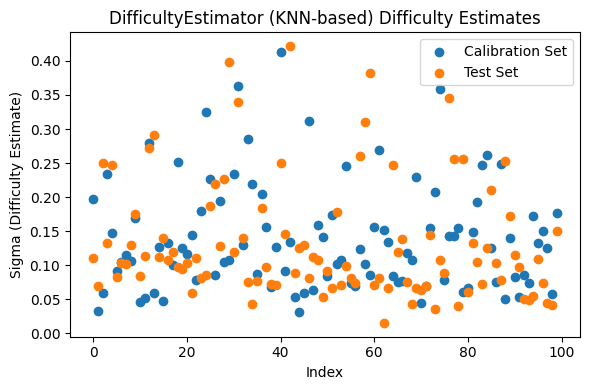

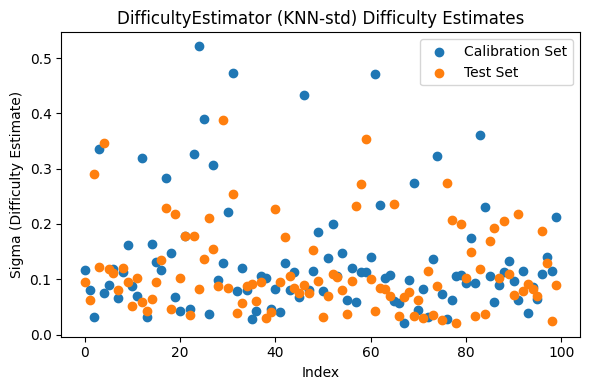

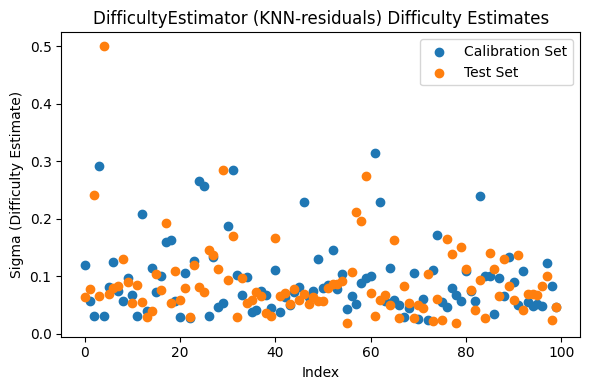

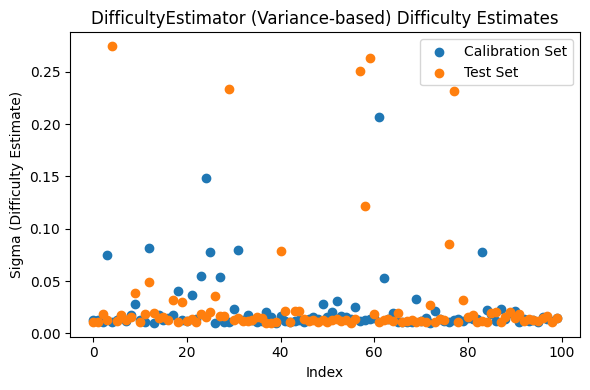

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# DifficultyEstimator (KNN-based)
plt.figure(figsize=(6, 4))
plt.scatter(range(100), sigmas_cal_knn_dist[:100], label='Calibration Set')
plt.scatter(range(100), sigmas_test_knn_dist[:100], label='Test Set')
plt.xlabel('Index')
plt.ylabel('Sigma (Difficulty Estimate)')
plt.title('DifficultyEstimator (KNN-based) Difficulty Estimates')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(range(100), sigmas_cal_knn_std[:100], label='Calibration Set')
plt.scatter(range(100), sigmas_test_knn_std[:100], label='Test Set')
plt.xlabel('Index')
plt.ylabel('Sigma (Difficulty Estimate)')
plt.title('DifficultyEstimator (KNN-std) Difficulty Estimates')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(range(100), sigmas_cal_knn_res[:100], label='Calibration Set')
plt.scatter(range(100), sigmas_test_knn_res[:100], label='Test Set')
plt.xlabel('Index')
plt.ylabel('Sigma (Difficulty Estimate)')
plt.title('DifficultyEstimator (KNN-residuals) Difficulty Estimates')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(range(100), sigmas_cal_var[:100], label='Calibration Set')
plt.scatter(range(100), de_var.apply(X_test[:100]), label='Test Set')
plt.xlabel('Index')
plt.ylabel('Sigma (Difficulty Estimate)')
plt.title('DifficultyEstimator (Variance-based) Difficulty Estimates')
plt.legend()
plt.tight_layout()
plt.show()

## Standard conformal regressors with out-of-bag calibration

In [38]:
learner_full = RandomForestRegressor(n_jobs=-1, n_estimators=500,
                                     oob_score=True)

learner_full.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True)

In [39]:
oob_predictions = learner_full.oob_prediction_

residuals_oob = y_train - oob_predictions

In [40]:
cr_std_oob = ConformalRegressor()

cr_std_oob.fit(residuals_oob)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

In [41]:
y_hat_full = learner_full.predict(X_test)

intervals_std_oob = cr_std_oob.predict(y_hat_full, y_min=0, y_max=1)

display(intervals_std_oob)

array([[0.01127921, 0.07086833],
       [0.        , 0.05892904],
       [0.03665657, 0.09624569],
       ...,
       [0.06713429, 0.12672341],
       [0.        , 0.05397975],
       [0.00436024, 0.06394936]])

In [42]:
de_var_oob = DifficultyEstimator()

de_var_oob.fit(X=X_train, learner=learner_full, scaler=True, oob=True)

display(de_var_oob)

sigmas_var_oob = de_var_oob.apply()

cr_norm_var_oob = ConformalRegressor()

cr_norm_var_oob.fit(residuals_oob, sigmas=sigmas_var_oob)

sigmas_test_var_oob = de_var_oob.apply(X_test)

intervals_norm_var_oob = cr_norm_var_oob.predict(y_hat_full,
                                                 sigmas=sigmas_test_var_oob,
                                                 y_min=0, y_max=1)

display(intervals_norm_var_oob)


DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=True)

array([[0.02520234, 0.0569452 ],
       [0.01298406, 0.04528492],
       [0.04457496, 0.08832729],
       ...,
       [0.07728557, 0.11657213],
       [0.00851372, 0.03985666],
       [0.01752652, 0.05078308]])

# Conformal prediction system (CPS)

In [43]:
cps_std = ConformalPredictiveSystem().fit(residuals_cal)

cps_norm = ConformalPredictiveSystem().fit(residuals_cal,
                                           sigmas=sigmas_cal_var)

cps_std_oob = ConformalPredictiveSystem().fit(residuals_oob)

cps_norm_oob = ConformalPredictiveSystem().fit(residuals_oob,
                                               sigmas=sigmas_var_oob)

In [44]:
bins_cal, bin_thresholds = binning(y_hat_cal, bins=5)

cps_mond_std = ConformalPredictiveSystem().fit(residuals_cal,
                                               bins=bins_cal)

cps_mond_norm = ConformalPredictiveSystem().fit(residuals_cal,
                                                sigmas=sigmas_cal_var,
                                                bins=bins_cal)


bins_oob, bin_thresholds_oob = binning(oob_predictions, bins=5)

cps_mond_std_oob = ConformalPredictiveSystem().fit(residuals_oob,
                                                   bins=bins_oob)

cps_mond_norm_oob = ConformalPredictiveSystem().fit(residuals_oob,
                                                    sigmas=sigmas_var_oob,
                                                    bins=bins_oob)

In [45]:
bins_test = binning(y_hat_test, bins=bin_thresholds)

bins_test_oob = binning(y_hat_full, bins=bin_thresholds_oob)

In [46]:
p_values = cps_mond_norm.predict(y_hat_test,
                                 sigmas=sigmas_test_knn_res,
                                 bins=bins_test,
                                 y=y_test)

display(p_values)

array([0.80749678, 0.62027139, 0.53529766, ..., 0.10872562, 0.3555251 ,
       0.49768223])

In [47]:
thresholds = cps_mond_norm.predict(y_hat_test,
                                   sigmas=sigmas_test_knn_res,
                                   bins=bins_test,
                                   higher_percentiles=50)

display(thresholds)

array([0.03649376, 0.02573321, 0.05075101, ..., 0.0953188 , 0.02314398,
       0.0292449 ])

In [48]:
results = cps_mond_norm.predict(y_hat_test,
                                sigmas=sigmas_test_knn_res,
                                bins=bins_test,
                                y=y_test,
                                lower_percentiles=[2.5, 5],
                                higher_percentiles=[95, 97.5])

display(results)

array([[ 0.8063207 , -0.03563407, -0.02440532,  0.08941569,  0.10038754],
       [ 0.62151825, -0.05804414, -0.04401708,  0.08427595,  0.11649397],
       [ 0.53420067, -0.21403494, -0.16881431,  0.30002615,  0.37963238],
       ...,
       [ 0.10827284,  0.05492169,  0.06544697,  0.14012266,  0.16076503],
       [ 0.35539381, -0.01604553, -0.00948392,  0.05052919,  0.06560019],
       [ 0.49735598, -0.0424941 , -0.03132588,  0.08188153,  0.09279423]])

In [49]:
cpds = cps_mond_norm.predict(y_hat_test,
                             sigmas=sigmas_test_knn_res,
                             bins=bins_test,
                             return_cpds=True)

print(f"No. of test instances: {len(y_hat_test)}")
print(f"Shape of cpds: {cpds.shape}")

No. of test instances: 10807
Shape of cpds: (10807,)


In [50]:
cpds = cps_mond_norm.predict(y_hat_test,
                             sigmas=sigmas_test_knn_res,
                             bins=bins_test,
                             return_cpds=True,
                             cpds_by_bins=True)

for i, cpd in enumerate(cpds):
    print(f"bin {i}: {cpd.shape[0]} test instances, {cpd.shape[1]} threshold values")

print(f"No. of test instances: {sum([c.shape[0] for c in cpds])}")

bin 0: 2028 test instances, 541 threshold values
bin 1: 2236 test instances, 540 threshold values
bin 2: 2209 test instances, 540 threshold values
bin 3: 2152 test instances, 540 threshold values
bin 4: 2182 test instances, 541 threshold values
No. of test instances: 10807


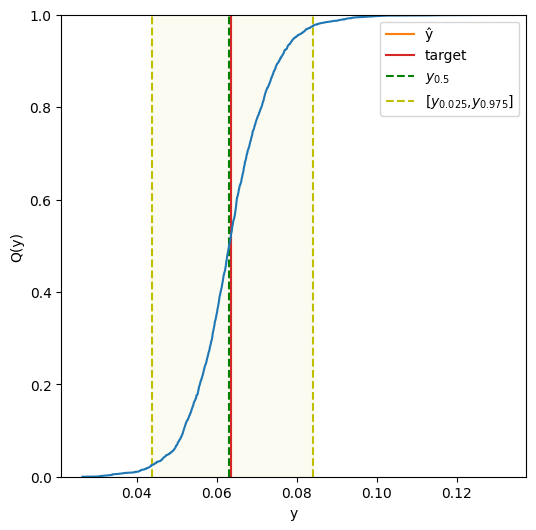

In [51]:
cpds = cps_mond_norm_oob.predict(y_hat_full,
                                 bins=bins_test_oob,
                                 sigmas=sigmas_test_var_oob,
                                 return_cpds=True)

test_index = np.random.randint(len(y_hat_full)) # A test object is randomly selected
cpd = cpds[test_index]

p = np.array([i/len(cpd) for i in range(len(cpd))])

lower_index = np.where(p<=0.025)[0][-1]
mid_index = np.where(p>=0.50)[0][0]
upper_index = np.where(p>=0.975)[0][0]

low_percentile = cpd[lower_index]
median = cpd[mid_index]
high_percentile = cpd[upper_index]

plt.figure(figsize=(6,6))
plt.plot([y_hat_full[test_index],y_hat_full[test_index]],[0,1], color="tab:orange")
plt.plot([y_test[test_index],y_test[test_index]],[0,1], color="tab:red")
plt.xlabel("y")
plt.ylabel("Q(y)")
plt.ylim(0,1)

plt.plot([median,median],[0,1],"g--")
plt.plot([low_percentile,low_percentile],[0,1],"y--")
plt.legend(["ŷ","target","$y_{0.5}$","[$y_{0.025}$,$y_{0.975}$]"])
plt.plot([high_percentile,high_percentile],[0,1],"y--")
plt.plot(cpd,p, color="tab:blue")
rectangle = plt.Rectangle((low_percentile,0),
                          abs(high_percentile-low_percentile),1, color="y",
                          alpha=0.05)
plt.gca().add_patch(rectangle)
plt.show()

In [53]:
all_cps = {"Std CPS":cps_std,
           "Std OOB CPS":cps_std_oob,
           "Norm CPS":cps_norm,
           "Norm OOB CPS":cps_norm_oob,
           "Mond CPS":cps_mond_std,
           "Mond OOB CPS":cps_mond_std_oob,
           "Mond norm CPS":cps_mond_norm,
           "Mond norm OOB CPS":cps_mond_norm_oob
          }

In [57]:
all_cps_intervals = {}

coverages = []
mean_sizes = []
median_sizes = []

for name in all_cps.keys():
    if "OOB" in name:
        intervals = all_cps[name].predict(y_hat_full,
                                          sigmas=sigmas_test_var_oob,
                                          bins=bins_test_oob,
                                          lower_percentiles=2.5,
                                          higher_percentiles=97.5,
                                          y_min=0, y_max=1)
    else:
        intervals = all_cps[name].predict(y_hat_test,
                                          sigmas=sigmas_test_var,
                                          bins=bins_test,
                                          lower_percentiles=2.5,
                                          higher_percentiles=97.5,
                                          y_min=0, y_max=1)
    all_cps_intervals[name] = intervals
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and
                                   y_test[i]<=intervals[i,1]) else 0
                            for i in range(len(y_test))])/len(y_test))
    mean_sizes.append((intervals[:,1]-intervals[:,0]).mean())
    median_sizes.append(np.median((intervals[:,1]-intervals[:,0])))

pred_int_df = pd.DataFrame({"Coverage":coverages,
                            "Mean size":mean_sizes,
                            "Median size":median_sizes},
                           index=list(all_cps_intervals.keys()))

pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(),
                           pred_int_df["Mean size"].mean(),
                           pred_int_df["Median size"].mean()]

display(pred_int_df.round(4).sort_values(by="Coverage", ascending=False))

,Coverage,Mean size,Median size
Mond OOB CPS,0.9518,0.0571,0.0396
Mond norm OOB CPS,0.9512,0.0530,0.0358
Norm CPS,0.9508,0.0590,0.0338
Mond CPS,0.9495,0.0578,0.0492
Mean,0.9494,0.0573,0.0440
Mond norm CPS,0.9489,0.0591,0.0348
Norm OOB CPS,0.9487,0.0508,0.0362
Std CPS,0.9473,0.0616,0.0623
Std OOB CPS,0.9469,0.0598,0.0607


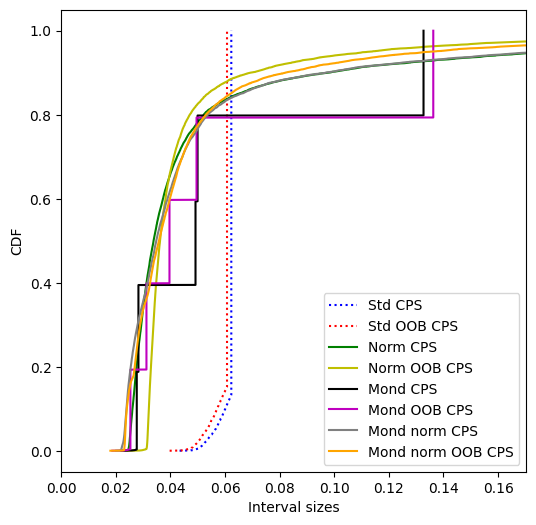

In [61]:

cps_interval_sizes = {}

for name in all_cps_intervals.keys():
    cps_interval_sizes[name] = \
    all_cps_intervals[name][:,1] - all_cps_intervals[name][:,0]

plt.figure(figsize=(6,6))
plt.ylabel("CDF")
plt.xlabel("Interval sizes")
plt.xlim(0,cps_interval_sizes["Mond OOB CPS"].max()*1.25)

colors = ["b","r","g","y","k","m", "gray", "orange"]

for i, name in enumerate(cps_interval_sizes.keys()):
    if "Std" in name:
        style = "dotted"
    else:
        style = "solid"
    plt.plot(np.sort(cps_interval_sizes[name]),
             [i/len(cps_interval_sizes[name])
              for i in range(1,len(cps_interval_sizes[name])+1)],
             linestyle=style, c=colors[i], label=name)

plt.legend()
plt.show()

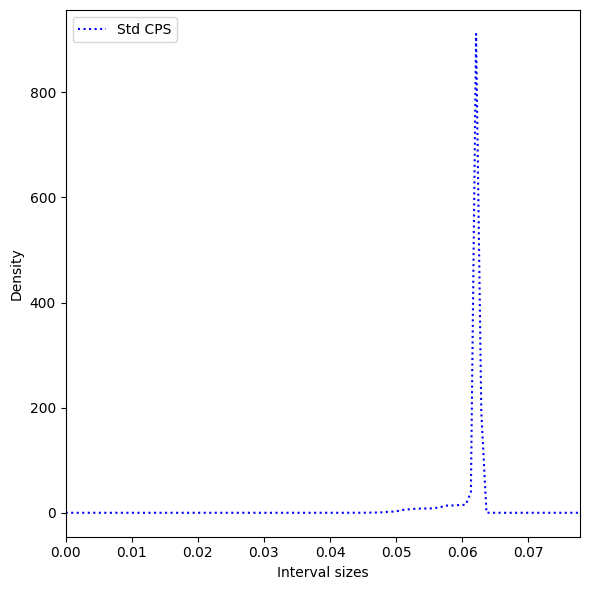

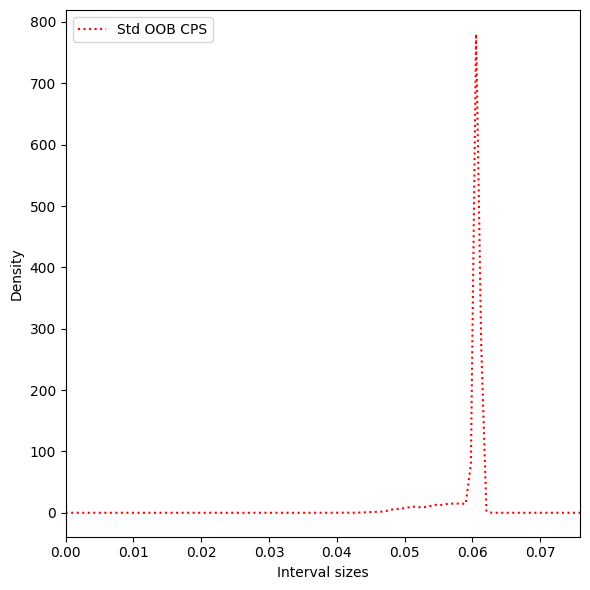

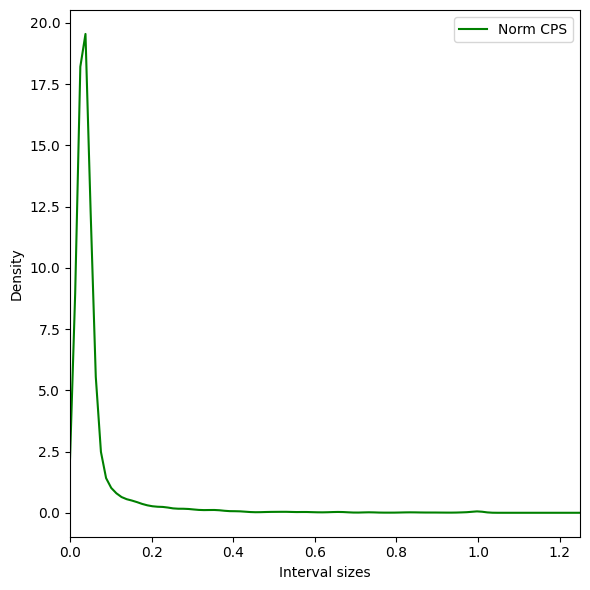

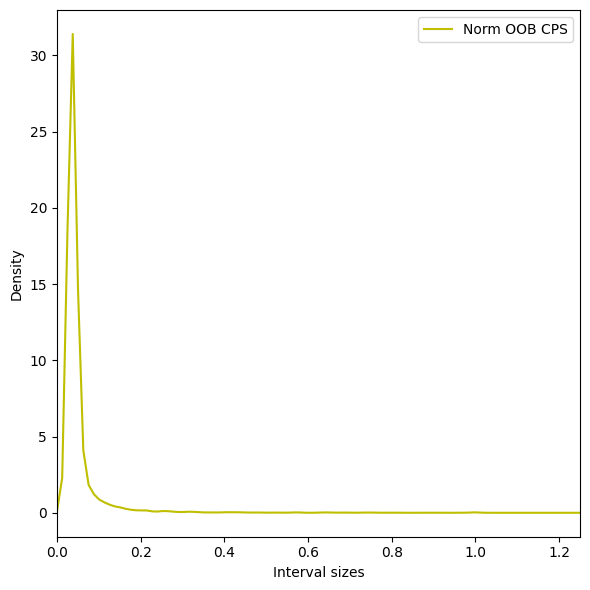

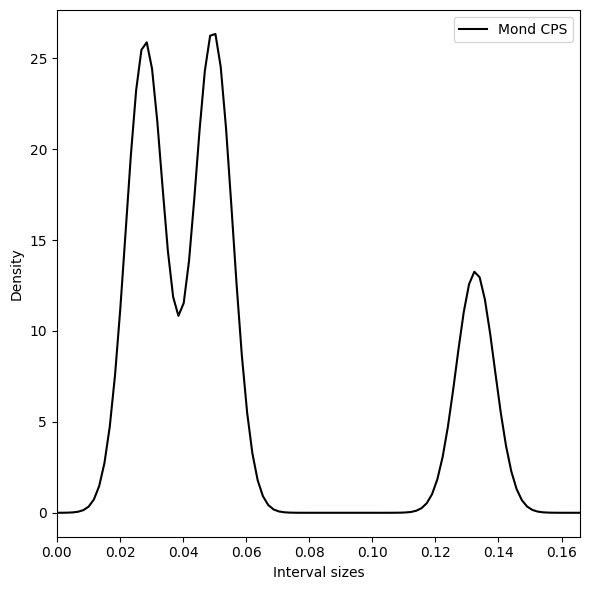

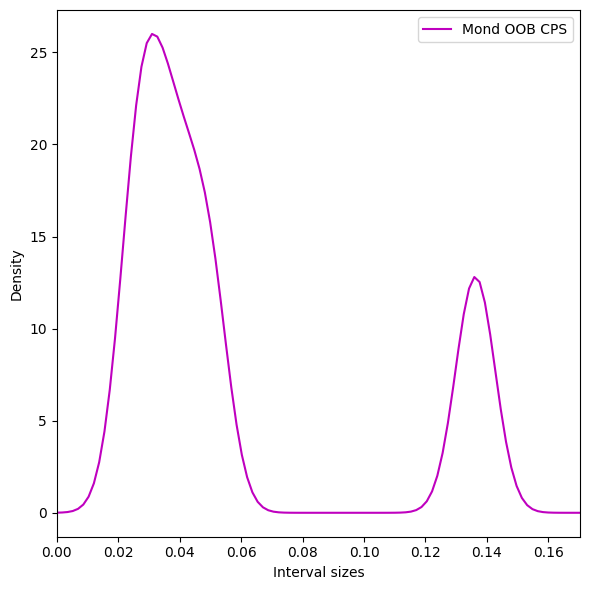

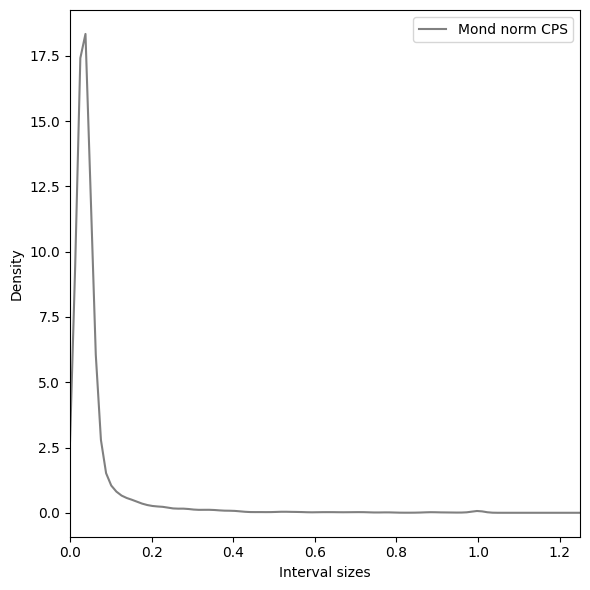

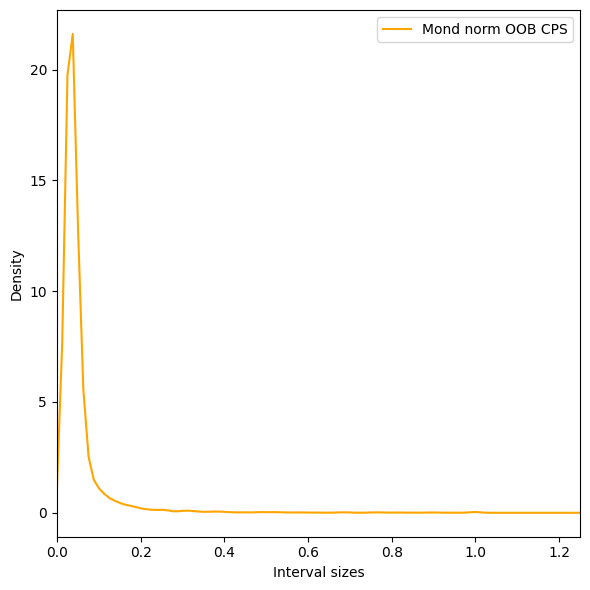

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

cps_interval_sizes = {}
for name in all_cps_intervals.keys():
    cps_interval_sizes[name] = all_cps_intervals[name][:, 1] - all_cps_intervals[name][:, 0]

colors = ["b", "r", "g", "y", "k", "m", "gray", "orange"]

for i, name in enumerate(cps_interval_sizes.keys()):
    if "Std" in name:
        style = "dotted"
    else:
        style = "solid"
    
    # Calculate the kernel density estimate
    kde = gaussian_kde(cps_interval_sizes[name])
    x = np.linspace(0, max(cps_interval_sizes[name]) * 1.25, 100)
    
    plt.figure(figsize=(6, 6))
    plt.ylabel("Density")
    plt.xlabel("Interval sizes")
    plt.xlim(0, max(cps_interval_sizes[name]) * 1.25)
    plt.plot(x, kde(x), linestyle=style, c=colors[i], label=name)
    plt.legend()
    plt.tight_layout()
    plt.show()